# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science: 

## Homework 6: Ensemble Methods, and Neural Networks


**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

## Assumed Skills:
This assignment presumes knowledge of the following skills:
- Familiarity with sklearn's model objects
- Cross validation to estimate models' future performance
- Booststrapping to build alternative datasets
- Some instruction on Keras' interface for building and training neural networks

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

C:\Users\Will\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.

In [3]:
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

In [4]:
data_train.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


In [5]:
X_train = data_train.iloc[:, data_train.columns != 'class']
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class']
y_test = data_test['class'].values

## Question 1 (12pts): A Single Model
We start by fitting a basic model we can compare the other models to. We'll pick an optimally-tuned decision tree as the base model, because we'll later include random forests and want a fair comparison.

<div class='exercise'> Question 1</div>
** 1.1**  Fit a decision tree model to the training set. Determine the depth-of-tree parameter via 5-fold cross-validation and plot the estimated performance +/- 2 standard deviations for the various depths.

** 1.2** Select an appropriate maximum depth-of-tree, and justify your choice.

**1.3** Report the model's classification accuracy on the test set.

**Answers**:  
**1.1:** Fit a decision tree model to the training set. Determine the depth-of-tree parameter via 5-fold cross-validation and plot the estimated performance +/- 2 standard deviations for the various depths.

In [6]:
%%time
cv_summary = []
cv_scores = []
for i in range(1,20):
    dt = DecisionTreeClassifier(max_depth=i)
    # Perform 5-fold cross validation and store results
    scores = cross_val_score(estimator=dt, X=X_train, y=y_train, cv=5)
    cv_summary.append((i,scores.mean(), scores.std()))
    cv_scores.append(scores)

# unpack out list-of-tuples into three separate lists
depthvals = [t[0] for t in cv_summary]
cvmeans = np.array([t[1] for t in cv_summary])
cvstds = np.array([t[2] for t in cv_summary])

Wall time: 10.8 s


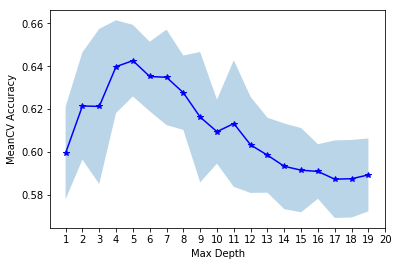

In [7]:
# plot means and shade the 2 SD interval
plt.plot(depthvals, cvmeans, 'b*-')
plt.fill_between(depthvals, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
plt.ylabel("MeanCV Accuracy")
plt.xlabel("Max Depth")
plt.xticks(range(1,21))
plt.show()

** 1.2** Select an apropriate maximum depth-of-tree, and justify your choice.

Although depth 5 has the highest CV score, there isn't enough evidence in the cross validation to distinguish it from depths of 4, 6, or even 7. You could justifiably pick any of these values, reasoning that 4 will give a simpler model that's less likely to overfit, or that the full model will be trained on 20% more data than the CV models and might support a greater depth. This analysis will move forward with a depth of 5.

**1.3** Report the model's classification accuracy on the test set.

In [8]:
best_depth = 5
fitted_tree = DecisionTreeClassifier(max_depth=best_depth).fit(X_train, y_train)
fitted_tree.score(X_test, y_test)

0.6478

The depth-5 tree gets a test accuracy of 64-65%.

## Question 2 (14 pts): Bagging
Bagging is the technique of building the same model on multiple bootstraps from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the combined accuracy.

<div class='exercise'> Question 2</div>
**2.1** Create 25 bootstrapped replications of the original training data, and fit a decision tree of depth 5 to each. Record each tree's prediction. In particular, produce a dataset like those below, where each row is a training example, each column is a tree from the forest, and each entry is that tree's prediction for that training example.

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 25's prediction|
| --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 25's prediction|
| --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

Store these results as `bagging_train` and `bagging_test`.

**2.2** _Aggregate_ all 25 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the 25 models predict that example to be from class 1. Verify that this bagging model scores either 67% or 68% accuracy on the test set.

**2.3** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracy as a function of number of bootstraps.

**2.4** Analyze the graph from 2.3 and discuss the effect of adding more bootstrapped models to the ensemble. What number of trees would you use in a production model to be cost-effective?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

In [9]:
def running_predictions(prediction_dataset, targets):
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset, where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss,axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

**Answers**:  
**2.1** Create 25 bootstrapped replications of the original training data, and fit a decision tree of depth 5 to each. Record each tree's prediction. In particular, produce a dataset like those below, where each row is a training example, each column is a tree from the forest, and each entry is that tree's prediction for that training example.

In [10]:
n_trees = 25
tree_depth = 5

bagging_train = np.zeros((X_train.shape[0],n_trees))
bagging_test = np.zeros((X_test.shape[0],n_trees))
for i in range(n_trees):
    bootstrapped_X, bootstrapped_y = resample(X_train,y_train)
    fitted_model = DecisionTreeClassifier(max_depth=tree_depth).fit(bootstrapped_X, bootstrapped_y)
    
    bagging_train[:,i] = fitted_model.predict(X_train)
    bagging_test[:,i] = fitted_model.predict(X_test)

pd.DataFrame(bagging_train, columns=["model"+str(x) for x in range(n_trees)]).head()

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


**2.2** _Aggregate_ all 25 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the 25 models predict that example to be from class 1. Verify that this bagging model scores either 67% or 68% accuracy on the test set.

In [11]:
bagging_train_predictions = np.mean(bagging_train,axis=1) >.5
bagging_test_predictions = np.mean(bagging_test,axis=1) >.5

np.sum(bagging_test_predictions == y_test)/len(y_test)

0.6786

**2.3** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracy as a function of number of bootstraps.

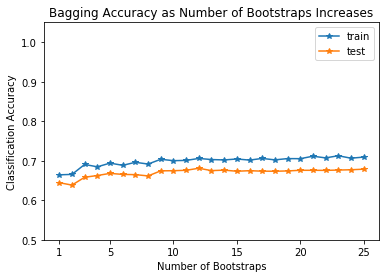

Final bootstrap ensemble test accuracy: 0.6786


In [12]:
train_history = running_predictions(bagging_train,y_train)
test_history = running_predictions(bagging_test,y_test)
plt.plot(range(1,n_trees+1),train_history,'*-',label='train')
plt.plot(range(1,n_trees+1),test_history,'*-',label='test')
plt.ylim(.5,1.05)
plt.xticks((1,5,10,15,20,25))
plt.xlabel("Number of Bootstraps")
plt.ylabel("Classification Accuracy")
plt.title("Bagging Accuracy as Number of Bootstraps Increases")
plt.legend();
plt.show()

print("Final bootstrap ensemble test accuracy:",test_history[-1])

The performance on both the training and test sets plateaus as we increase the number of trees. At a certain point we've seen enough bootstrapped datasets to have squished out all the variance we can.

**2.4** Analyze the graph from 2.3 and discuss the effect of adding more bootstrapped models to the ensemble. What number of trees would you use in a production model to be cost-effective?

To be cost effective, it looks as if we'd only need 5-10 trees in the model. Performance has leveled off by that point and including more trees would cost computation without really benefitting the model.

## Question 3 (6 pts): Random Forests
Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.

<div class='exercise'> Question 3</div>
**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using 25 trees and a depth of 5. Comment on the model's test performance compared to the bagging model from Question 2.

**3.2** There are two improvements Random Forests make to the pure bagging approach in Question 2. What are they, and how do they help the random forest model do better than the pure bagging model?

**Hints**:
 - Random forests do not combine each tree's prediction via a majority vote. What do they use instead?

## **Answers**:  
**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using 25 trees and a depth of 5. Comment on the model's test performance compared to the model from Question 2.

In [13]:
fitted_rf = RandomForestClassifier(n_estimators=25, max_depth=5).fit(X_train,y_train)
fitted_rf.score(X_test,y_test)

0.6824

The full random forest scores 67-68% accuracy, so the random forest classifier does approximately as well as the DIY bootstrap on this data. Repeated runs of each model might show a slight advantage for the random forest.

**3.2** There are two improvements Random Forests make to the pure bagging approach in Question 2. What are they, and how do they help the random forest model do better than the pure bagging model?

1. Random forests work with the _probability_ estimated by each model, rather than its final prediction. When available, these sorts of confidence scores carry more information than the model's final prediction, especially when predicting from among many classes.
2. Beyond training each tree on a different bootstrap resample, the random forest additionally restricts each tree to a subset of the full feature set. This strongly decreases the cost to fit each tree at the expense of greater variation in the predictions of each tree. However, these extra variations can easily be averaged out as more trees are added.

## Question 4 (12 pts): Boosting
In this question we explore a counterpart to bagging, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy over the algorithm's run.

<div class='exercise'> Question 4</div>
**4.1** Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 400 iterations. Use the `staged_score` method to help make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.  

**4.2** Repeat the plot above for a base learner with depth in (1,2,3,4). What trends do you see in the training and test accuracy?

**4.3** Based on the plot from 4.2, what combination of base learner depth and number of iterations seems optimal? Why?

**4.4** AdaBoost doesn't combine its sub-models via simple majority vote, or by averaging probabilities. What does it use instead, and why do you think that combination rule was chosen?

**Answers**:  
**4.1** Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 400 iterations. Use the `staged_score` method to help make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

Wall time: 25.5 s


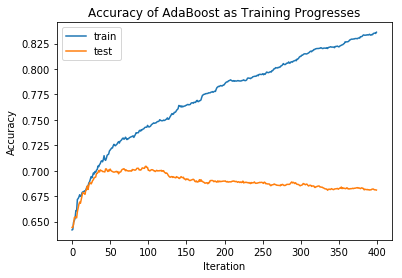

In [14]:
%%time
fitted_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),n_estimators=400, learning_rate=.05).fit(X_train,y_train)
train_scores = list(fitted_ada.staged_score(X_train,y_train))
test_scores = list(fitted_ada.staged_score(X_test, y_test))

plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Accuracy of AdaBoost as Training Progresses")
plt.legend();

**4.2** Repeat the plot above for a base learner with depth in (1,2,3,4). What trends do you see in the training and test accuracy?

Wall time: 1min 30s


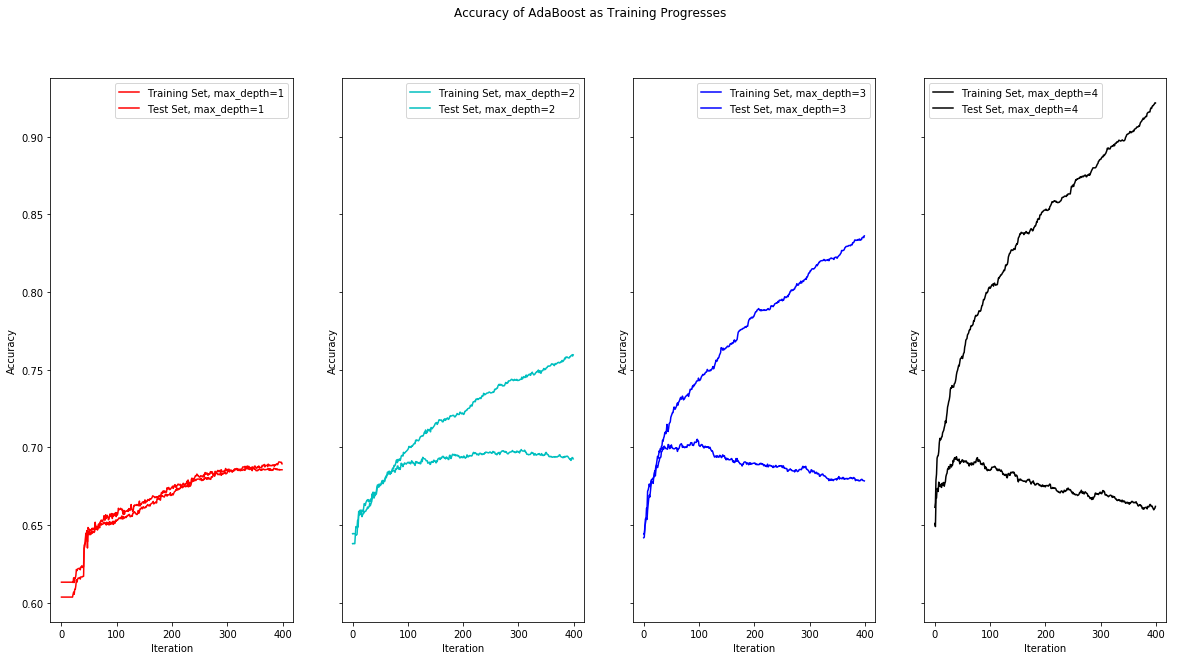

In [15]:
%%time
fig, ax = plt.subplots(1,4, figsize=(20,10), sharey=True)

colors = ['r','c','b','k']
ax = ax.ravel()
for i, cur_depth in enumerate((1,2,3,4)):
    cur_ax = ax[i]
    fitted_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=cur_depth),n_estimators=400, learning_rate=.05).fit(X_train,y_train)
    train_scores = list(fitted_ada.staged_score(X_train,y_train))
    test_scores = list(fitted_ada.staged_score(X_test, y_test))

    cur_ax.plot(train_scores, color= colors[i], label='Training Set, max_depth='+str(cur_depth))
    cur_ax.plot(test_scores, color= colors[i], label='Test Set, max_depth='+str(cur_depth), ls='-')
    cur_ax.set_xlabel('Iteration')
    cur_ax.set_ylabel('Accuracy')
    cur_ax.legend();
plt.suptitle("Accuracy of AdaBoost as Training Progresses")

The training accuracies all steadily improve as we run the boosting, but at some point they each start to overfit and test accuracy levels off or decreases (except when the base learner is the simplest tree of depth 1).

**4.3** Based on the plot from 4.2, what combination of base learner depth and number of iterations seems optimal? Why?

A model with depth 2 and about 90-100 iterations seems optimal, as that combination has very similar test and train performance, indicating the model has not overfit. However, other settings (e.g. 3 learners and about 75 iterations) achieve higher test accuracy and could be good choices if you trust that the test set is representative of future data.

**4.4** AdaBoost doesn't combine its sub-models via simple majority vote, or by averaging probabilities. What does it use instead, and why do you think that combination rule was chosen?

Adaboost gives greater weights to models that perform better on thier target version of the training data. In particular, the weight is $\frac{1}{2}ln\left(\frac{1-\epsilon}{\epsilon}\right)$, where $\epsilon$ is that model's (weighted) accuracy on its training set. Ergo, models that better fit thier training data get exponentially more weight.

In practice, this rule gives smaller and smaller weight to models found in later iterations (the 'learning rate' parameter governs how much weight is assigned). This rule makes sense because AdaBoost's later models can be highly incentivized to chase after the few examples being mispredicted even if it means giving poor results on well-predicted training points. The weighted voting rule means that when the earlier, general-purpose models agree the later models don't factor in, but when the early models are split the later models can act as a tie-breaker.


## Question 5 (18 pts): Ensembling
In this question we take the running theme of combining model to its extreme. So far, we have been combining the predictions of relatively bad models; in this section we'll combine several strong models and achieve our best accuracy yet.

We provide well-tuned models in the file `models.pkl`. The code below will read in this data for you. The model_dict object contains 5 tuned models, under the names "Ada", "KNN", "Logit", "QDA", and "RF".

**5.1**: Report each of the 5 tuned models' score on the test set, so that you can compare to these scores later.

**5.2**: Read in the fresh dataset `data/Higgs_tune.csv` Similar to 2.1, build `ensemble_tune` and `ensemble_test`, datasets containing each tuned model's prediction of P(this point belongs to class 1) for each of the tuning and test points.

**5.3**: Build a meta-model trained on `ensemble_tune` and predicting the tuning set labels (e.g., a LogisticRegression or RandomForest). Which model does your meta-model consider most important, and how well does your meta-model perform on the test set?

**5.4**: Augment the `ensemble_tune` and `ensemble_test` datasets with the columns from the original tuning and test data to form `augmented_tune` and `augmented_test`. Fit a decision tree model to this new tuning data (max depth 5, no mximum number of features).

**5.5**: How well does the meta-tree do on the test set? Why does training a decision tree on the combination of original data and model predictions perform so well?

**5.6**: Suggest one way to improve on the model above

In [16]:
# will produce a warning under most versions of SKlearn, but it should be OK to ignore
# if you get weird errors or the models all stink, let us know

import pickle
with open("data/models.pkl", 'rb') as infile:
    model_dict = pickle.load(infile)

**Answers**:

**5.1**: Report each model's score on the test set, so that you can compare to these scores later.

In [17]:
print("Test Set Accuracy")
for cur_name, cur_model in model_dict.items():
    print("  {}: {}".format(cur_name, cur_model.score(X_test,y_test)))

Test Set Accuracy
  Ada: 0.6756
  RF: 0.6748
  Logit: 0.6384
  QDA: 0.633
  KNN: 0.5774


**5.2**: Read in the fresh dataset `./Higgs_tune.csv`.  Similar to 2.1, build `ensemble_tune` and `ensemble_test`, datasets containing each tuned model's prediction of P(this point belongs to class 1) for each of the tuning and test points.

In [18]:
data_tune = pd.read_csv('data/Higgs_tune.csv')

X_tune = data_tune.iloc[:, data_train.columns != 'class']
y_tune = data_tune['class'].values

In [19]:
ensemble_tune = pd.DataFrame()
ensemble_test = pd.DataFrame()

for cur_name,cur_model in model_dict.items():
    ensemble_tune[cur_name] = cur_model.predict_proba(X_tune)[:,1]
    ensemble_test[cur_name] = cur_model.predict_proba(X_test)[:,1]
ensemble_tune.head()

,Ada,RF,Logit,QDA,KNN
0,0.476499,0.497049,0.713247,0.867147,0.60
1,0.548898,0.549102,0.629934,0.766266,0.50
2,0.455639,0.418363,0.437730,0.174581,0.70
3,0.489579,0.451090,0.759375,0.759620,0.64
4,0.465777,0.355656,0.202824,0.005958,0.50


**5.3**: Build a meta-model trained on `ensemble_tune` and predicting the tuning set labels (e.g., a LogisticRegression or RandomForest). Which model does your meta-model consider most important, and how well does your meta-model perform on the test set?

In [20]:
logistic_meta_model = LogisticRegressionCV().fit(ensemble_tune, y_tune)

print("Learned Coeficients:", logistic_meta_model.coef_)
print("Test Set Accuracy:", logistic_meta_model.score(ensemble_test, y_test))

Learned Coeficients: [[ 8.22652276  3.06706045  1.28924669  0.42076795 -0.21155845]]
Test Set Accuracy: 0.6956


In [21]:
rf_meta_model = RandomForestClassifier(max_depth=5).fit(ensemble_tune, y_tune)

print("Learned Coeficients:", rf_meta_model.feature_importances_)
print("Test Set Accuracy:", rf_meta_model.score(ensemble_test, y_test))

Learned Coeficients: [0.29835694 0.3269024  0.20582382 0.14164212 0.02727472]
Test Set Accuracy: 0.7056


The logistic model puts the its highest weight on the AdaBoost model, and less weight on each successive model, in line with their prediction accuracies. The random forest finds the random forest model's predictions to be most useful.

**5.4**: Augment the `ensemble_tune` and `ensemble_test` datasets with the columns from the original tuning and test data to form `augmented_tune` and `augmented_test`. Fit a decision tree model to this new tuning data (max depth 5, no mximum number of features).

In [22]:
augmented_tune = pd.concat([ensemble_tune, X_tune], axis=1)
augmented_test = pd.concat([ensemble_test, X_test], axis=1)
augmented_tune.head()

,Ada,RF,Logit,QDA,KNN,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.476499,0.497049,0.713247,0.867147,0.60,0.717,-0.450,-0.0435,0.975,1.430,0.845,0.264,1.500,0.00,0.679,0.342,-1.570,0.00,0.977,0.704,-0.0185,2.55,0.713,-1.1200,0.494,0.0,1.230,1.050,1.12,0.710,0.540,0.673,0.655
1,0.548898,0.549102,0.629934,0.766266,0.50,0.719,1.390,0.1020,1.140,1.240,0.758,2.740,-1.030,0.00,0.660,0.804,1.070,2.21,0.418,1.570,-0.2030,0.00,0.771,-0.7270,-0.456,3.1,0.879,1.230,1.07,1.080,0.882,1.210,1.010
2,0.455639,0.418363,0.437730,0.174581,0.70,2.320,0.074,-0.6260,0.909,-0.795,1.240,-0.418,1.200,0.00,0.463,-0.355,0.151,2.21,0.683,0.717,0.6810,2.55,0.431,0.0978,-1.690,0.0,0.640,0.768,1.01,0.945,0.456,0.695,0.905
3,0.489579,0.451090,0.759375,0.759620,0.64,0.626,-0.346,-1.5800,2.100,0.878,1.140,-0.341,-1.150,0.00,0.415,-0.549,-0.313,2.21,1.620,-0.330,0.2520,2.55,0.517,1.5800,-1.690,0.0,1.700,1.100,1.27,0.973,0.433,0.971,0.977
4,0.465777,0.355656,0.202824,0.005958,0.50,0.320,-1.100,-0.8350,2.770,1.210,1.280,0.453,-0.698,2.17,1.140,0.221,0.602,2.21,1.290,1.060,-1.0500,0.00,0.734,1.6100,0.331,0.0,1.100,1.120,1.26,1.330,1.650,1.570,1.550


In [23]:
tree_meta = DecisionTreeClassifier(max_depth=5, max_features=None).fit(augmented_tune,y_tune)

**5.5**: How well does the meta-tree do on the test set? Why does training a decision tree on the combination of original data and model predictions perform so well?

In [24]:
print("DT meta-model test accuracy:", tree_meta.score(augmented_test, y_test))

DT meta-model test accuracy: 0.7036


The RF meta-model using both the original data and the trained model's predictions scores about 69% accuracy on the test set, better than any component model.

The meta-model does well becuase it is able to build rules specifying which of the original models to listen to based on which region of the input space the given point is in. Note: using a random forest in place of a single tree helps combat over-learning complex rules.

Without the original columns, the meta-model can't use information about where a point is in the original feature space. Using a logistic regression in place of a tree is less flexible about which original model is used when.

**5.6**: Suggest one way to improve on the model above

In [25]:
rf_meta = RandomForestClassifier(400, max_depth=5).fit(augmented_tune,y_tune)
print("RF meta-model test accuracy:", rf_meta.score(augmented_test, y_test))

RF meta-model test accuracy: 0.7186


If one tree is good, a forest must be better!

## Question 6 (12 pts): Understanding
This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.

<div class='exercise'> Question 6</div>
**6.1** How do ensembling, boosting, and bagging all relate: what is common to all three, and what is unique to each of them?

**6.2** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**6.3** What is the impact of having too many trees/iterations in boosting and in bagging? In which instance is it worse to overshoot?

**6.4** Suppose you have 10,000 training observations and have selected (non-polynomial) linear regression as your base model. Which technique will help your model more, boosting or bagging? How does your choice (and boosting/bagging in general) tie to overfitting versus underfitting?

**Answers**:  
**6.1** How do ensembling, boosting, and bagging all relate: what is common to all three, and what is unique to each of them?

Bagging and Boosting are special cases of Ensembling. In Ensembling we take the set of models we combine as essentially given; in Bagging and Boosting we build the set of models in a particular way. In bagging, each model is trained on a fresh bootstrap of the original data. In boosting, each model is trained on a re-weighted copy of the original data where points that are presently being mispredicted get more weight.

**6.2** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

Bagging is much better suited to parallelization. In bagging we can train the N models independently, while in boosting we have to wait for the Nth model to finish fitting before we can train the N+1st model.

**6.3** What is the impact of having too many trees/iterations in boosting and in bagging? In which instance is it worse to overshoot?

Having too many trees in bagging isn't much of an issue- test performance will plateau. In contrast, running boosting for too long will begin to overfit the data and hurt the overall accuracy.

**6.4** Suppose you have 10,000 training examples and have selected (non-polynomial) linear regression as your base model. Which technique will help your model more, boosting or bagging? How does your choice (and boosting/bagging in general) tie to overfitting versus underfitting?

Boosting will help more in this situation. In terms of bias and variance, Boosting helps a model move towards overfitting and Bagging helps an overfit model relax and not chase the dataset-specific noise. The situation described is likely to be underfit / high bias and low variance, so boosting should help get more power out of the model.

However, boosting does not actually work on linear models. Even a weighted combination of many linear models will still just be some line, and thus no better than the original linear model. Baqgging is also unlikely to help much in practice: the predictions on each bootstrapped dataset probably won't differ much, so it would be only barely stronger than using a single line.

<hr style='height:2pt'>
## Question 7 (26 points): Neural Networks
Neural networks are, of course, a large and complex topic that cannot be covered in a single homework. Here we'll focus on the key idea of NNs: they are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size). We'll also partially explore what patterns the neural network learns and how well they generalize.

In this question we'll see if Neural Networks can learn a (limited) version of the Fourier Transform. (The Fourier Transform takes in values from some function and returns a set of sine and cosine functions which, when added together, approximate the original function.)

In our specific problem, we'll try to teach a network to map from  a function's 1000 sample y-values to the four features of the sine and cosine waves that make up that function. Thus, the network is attempting to learn a mapping from a 1000-entry vector down to a 4-entry vector. Our X_train dataset is thus N by 1000 and our y_train is N by 4. 

We'll use 6 data files in this question:
- `sinewaves_X_train.npy` and `sinewaves_y_train.npy`: a (10,000 by 1,000) and (10,000 by 4) training dataset. Examples were generated by randomly selecting a,b,c,d in the interval [0,1] and building the curve $a\sin(b\,x) + c\cos(d\,x)$
- `sinewaves_X_test.npy` and `sinewaves_y_test.npy`: a (2,000 by 1,000) and (2,000 by 4) test dataset, generated in the same way as the training data
- `sinewaves_X_extended_test` and `sinewaves_y_extended_test`: a (9 by 1,000) and (9 by 4) test dataset, testing whether the network can generalize beyond the training data (e.g. to negative values of $a$)

**These datasets are read in to their respective variables for you.**

<div class='exercise'> Question 7</div>
**7.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

**7.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.24\sin(0.533\,x) + 0.018\cos(0.558\,x)$. This pattern (y_train is the true parameters of the curve in X_train) will always hold.

**7.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

**7.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

**7.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of 0.2. You can train for longer if you wish- the fit tends to improve over time.

**7.6** Use the `plot_predictions` function to plot the model's predictions on `X_test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefficients that generated the data?

**7.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

**7.8** Is there something that stands out about the difficult examples, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

**Hint**:
- Keras's documentation and examples of a Sequential model are a good place to start.
- A strong model can achieve validation error of around 0.03 on this data and 0.02 is very good.

In [26]:
def plot_predictions(model, test_x, test_y, count=None):
    # Model - a Keras or SKlearn model that takes in (n,1000) training data and predicts (n,4) output data
    # test_x - a (n,1000) input dataset
    # test_y - a (n,4) output dataset
    # This function will plot the sine curves in the training data and those implied by the model's predictions.
    # It will also print the predicted and actual output values.
    
    #helper function that takes the n by 4 output and reverse-engineers 
    #the sine curves that output would create
    def y2x(y_data):
        #extract parameters
        a=y_data[:,0].reshape(-1,1)
        b=y_data[:,1].reshape(-1,1)
        c=y_data[:,2].reshape(-1,1)
        d=y_data[:,3].reshape(-1,1)

        #build the matching training data
        x_points = np.linspace(0,10*np.pi,1000)
        x_data = a*np.sin(np.outer(b,x_points)) + c*np.cos(np.outer(d,x_points))
        return x_data
    
    #if <20 examples, plot all. If more, just plot 5
    if count==None:
        if test_x.shape[0]>20:
            count=5
        else:
            count=test_x.shape[0]
    
    #build predictions
    predicted = model.predict(test_x)
    implied_x = y2x(predicted)
    for i in range(count):
        plt.plot(test_x[i,:],label='true')
        plt.plot(implied_x[i,:],label='predicted')
        plt.legend()
        plt.ylim(-2.1,2.1)
        plt.xlabel("x value")
        plt.xlabel("y value")
        plt.title("Curves using the Neural Network's Approximate Fourier Transform")
        plt.show()
        print("true:", test_y[i,:])
        print("predicted:", predicted[i,:])
    
    

In [27]:
X_train = np.load('data/sinewaves_X_train.npy')
y_train = np.load('data/sinewaves_y_train.npy')

X_test = np.load('data/sinewaves_X_test.npy')
y_test = np.load('data/sinewaves_y_test.npy')

X_extended_test = np.load('data/sinewaves_X_extended_test.npy')
y_extended_test = np.load('data/sinewaves_y_extended_test.npy')

**Answer**:  
**7.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

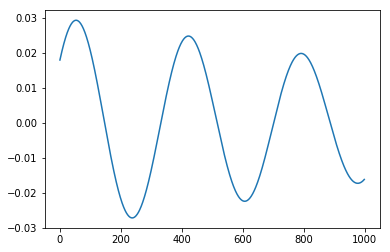

In [28]:
plt.plot(X_train[0,:]);

**7.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced points in $[0,10\pi]$ from the function $f(x) = 0.24\sin(0.533\,x) + 0.018\cos(0.558\,x)$...

In [29]:
y_train[0,:]

array([0.024, 0.533, 0.018, 0.558])

Are all entries equal? True


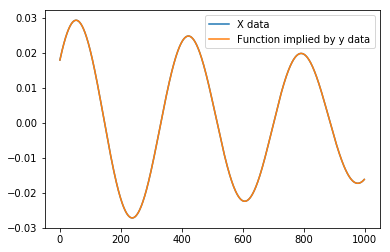

In [30]:
x_points = np.linspace(0,10*np.pi,1000)
train_from_test = 0.024*np.sin(0.533*x_points) + 0.018*np.cos(0.558*x_points)
plt.plot(X_train[0,:], label="X data")
plt.plot(train_from_test, label="Function implied by y data")
plt.legend();

print("Are all entries equal?", np.all(X_train[0,:]==train_from_test))

**7.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

In [31]:
model = Sequential([
    Dense(200, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(4, activation='linear')
])

**7.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

In [32]:
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               200200    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 204       
Total params: 225,554
Trainable params: 225,554
Non-trainable params: 0
_________________________________________________________________


The 200,200 parameters in the first layer come from a 200 nodes, each holding a weight for the 1000 inputs (200,000 weights) and the intercept for each of the 200 nodes (an additional 200 weights).

**7.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of .2. You can train for longer if you wish- the fit tends to improve over time.

In [33]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 2s 301us/step - loss: 0.1453 - val_loss: 0.1023
Epoch 2/50
8000/8000 [==============================] - 2s 254us/step - loss: 0.0916 - val_loss: 0.0808
Epoch 3/50
8000/8000 [==============================] - 2s 250us/step - loss: 0.0756 - val_loss: 0.0685
Epoch 4/50
8000/8000 [==============================] - 2s 217us/step - loss: 0.0642 - val_loss: 0.0662
Epoch 5/50
8000/8000 [==============================] - 2s 230us/step - loss: 0.0578 - val_loss: 0.0582
Epoch 6/50
8000/8000 [==============================] - 2s 243us/step - loss: 0.0523 - val_loss: 0.0490
Epoch 7/50
8000/8000 [==============================] - 2s 204us/step - loss: 0.0489 - val_loss: 0.0513
Epoch 8/50
8000/8000 [==============================] - 2s 240us/step - loss: 0.0463 - val_loss: 0.0496
Epoch 9/50
8000/8000 [==============================] - 2s 229us/step - loss: 0.0443 - val_loss: 0.0458
Epoch 10/50
8000

**7.6** Use the `plot_predictions` function to plot the model's predictions on `X-test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?

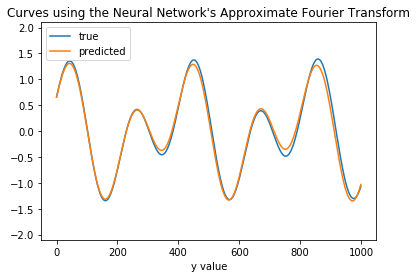

true: [0.86199664 0.98175913 0.65523998 0.4870337 ]
predicted: [0.8169355 0.984395  0.6545371 0.4956026]


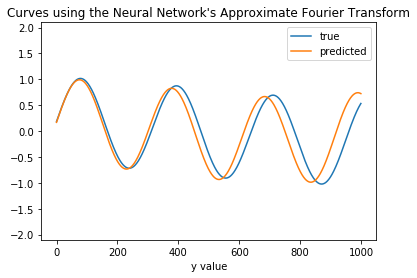

true: [0.8406355  0.63159555 0.18328701 0.11174618]
predicted: [0.8303203  0.65768814 0.16901545 0.13381939]


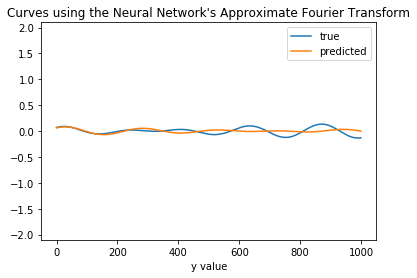

true: [0.06591224 0.75183886 0.06986143 0.91352303]
predicted: [0.05788106 0.7421682  0.06176283 0.8143358 ]


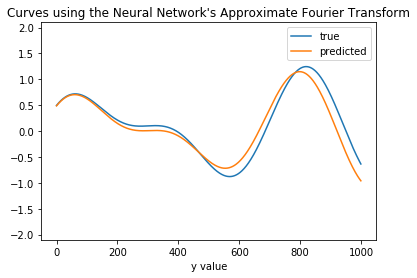

true: [0.75610725 0.30861152 0.49522059 0.48394499]
predicted: [0.7121993  0.3248514  0.4871593  0.48919278]


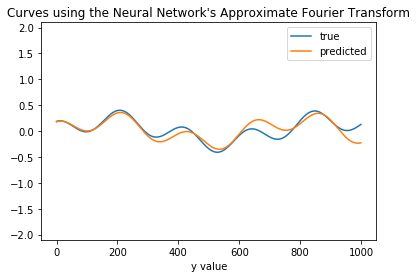

true: [0.2229353  0.27885697 0.18696198 0.94846283]
predicted: [0.20972794 0.31380215 0.17830439 0.92176944]


In [34]:
plot_predictions(model,X_test,y_test)

In [35]:
model.evaluate(X_test,y_test)

2000/2000 [==============================] - 0s 55us/step


0.026383354514837264

The model is, in most cases, doing a very good job pinning down the correct coefficients. It seems to be making numerical errors on the order of +/- .02, and this error decreases with further training. The model has a total loss of 0.3, in line with the training and validation error. It looks like the model has learned the mapping from data to the coefficients that generated the data.

**7.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

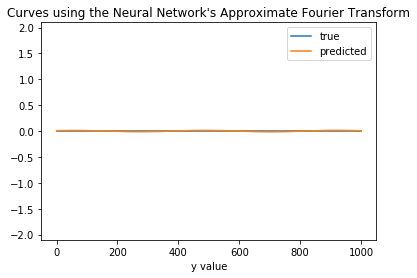

true: [0. 0. 0. 0.]
predicted: [0.00805332 0.4744709  0.00790442 0.4504478 ]


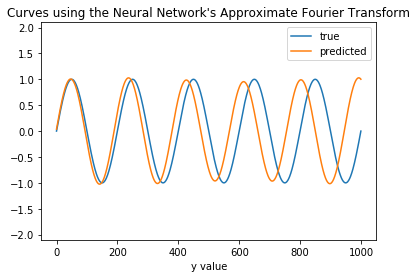

true: [1. 1. 0. 0.]
predicted: [0.9917088  1.0571934  0.03720506 0.8101658 ]


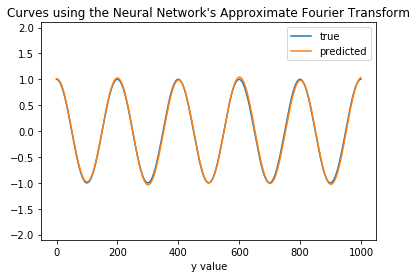

true: [0. 0. 1. 1.]
predicted: [0.03173969 0.42532024 1.011577   0.99770176]


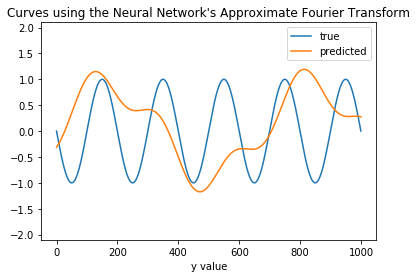

true: [-1.  1.  0.  0.]
predicted: [ 0.92242247  0.2970049  -0.31211767  0.8706593 ]


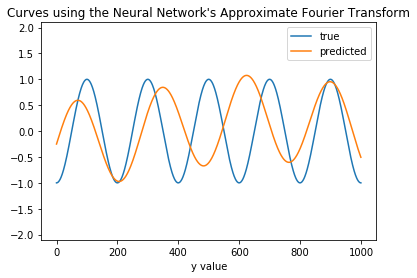

true: [ 0.  0. -1.  1.]
predicted: [ 0.83180934  0.7213081  -0.2501616   0.14868107]


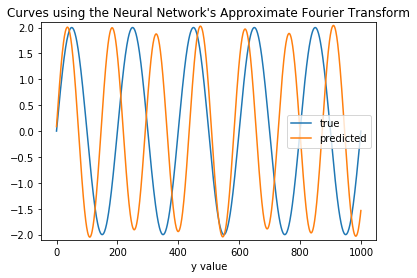

true: [2. 1. 0. 0.]
predicted: [1.9611394  1.3735194  0.08703903 0.8941059 ]


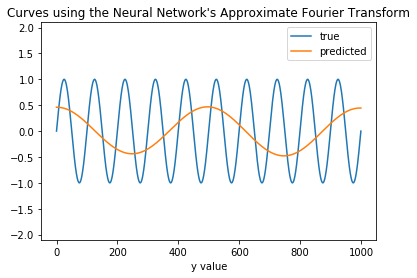

true: [1. 2. 0. 0.]
predicted: [0.02196733 0.1765576  0.46012518 0.40190366]


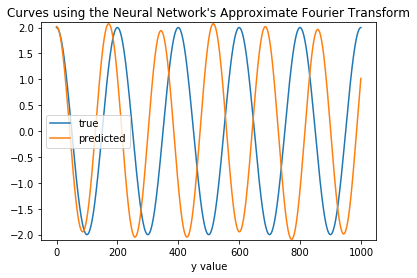

true: [0. 0. 2. 1.]
predicted: [0.07821433 0.4376336  2.0176992  1.165503  ]


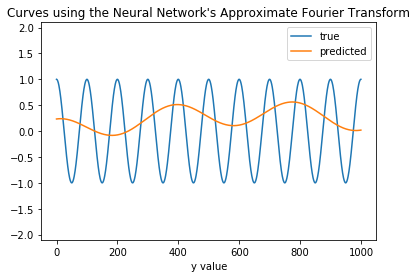

true: [0. 0. 1. 2.]
predicted: [0.34348902 0.0765004  0.2336505  0.5136711 ]


In [36]:
plot_predictions(model,X_extended_test,y_extended_test)

The model does well on examples with coefficients in the range $[0,1]$ but struggles when coefficients are negative or bigger than 1.

**7.8** Is there something that stands out about the difficult observations, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

The model is struggling to accurately predict answers on data outside the examples given in training. Even so, it is easily able to provide correct answers for new data _from the same distribution as the training data_. The network is not overfit nor underfit- it performs equally well on its training data as on held-out test data.

However, although the model learned _a_ rule for mapping from its training input to the example outputs, it did not learn the rule we had in mind, and the model does not extend beyond the kinds of examples it was trained on.  This is a form of extrapolation.

**Instructor's note**: This is a common theme with neural networks and other black-box learners: they will figure out a rule that works on the data they are trained on, but that rule is unlikely to extend beyond the range of the training examples. Collecting good data is the most important analytic step!